## Logistic/Softmax Regression
A simple multi-event classifier model to predict activity type.

Resources: 
- https://www.skytowner.com/explore/comprehensive_guide_on_logistic_regression

1. Load data

In [98]:
from pathlib import Path
import polars as pl

from lisa.config import PROCESSED_DATA_DIR

input_path: Path = PROCESSED_DATA_DIR / "pilot_data.csv"

df = pl.read_csv(input_path)

df

TRIAL,TIME,first_Electric Potential.1,last_Electric Potential.1,max_Electric Potential.1,min_Electric Potential.1,mean_Electric Potential.1,std_Electric Potential.1,first_D1_Global Angle.x,last_D1_Global Angle.x,max_D1_Global Angle.x,min_D1_Global Angle.x,mean_D1_Global Angle.x,std_D1_Global Angle.x,first_D1_Global Angle.y,last_D1_Global Angle.y,max_D1_Global Angle.y,min_D1_Global Angle.y,mean_D1_Global Angle.y,std_D1_Global Angle.y,first_D1_Global Angle.z,last_D1_Global Angle.z,max_D1_Global Angle.z,min_D1_Global Angle.z,mean_D1_Global Angle.z,std_D1_Global Angle.z,first_D1_HighG.x,last_D1_HighG.x,max_D1_HighG.x,min_D1_HighG.x,mean_D1_HighG.x,std_D1_HighG.x,first_D1_HighG.y,last_D1_HighG.y,max_D1_HighG.y,min_D1_HighG.y,mean_D1_HighG.y,…,first_D7_gyro.x,last_D7_gyro.x,max_D7_gyro.x,min_D7_gyro.x,mean_D7_gyro.x,std_D7_gyro.x,first_D7_gyro.y,last_D7_gyro.y,max_D7_gyro.y,min_D7_gyro.y,mean_D7_gyro.y,std_D7_gyro.y,first_D7_gyro.z,last_D7_gyro.z,max_D7_gyro.z,min_D7_gyro.z,mean_D7_gyro.z,std_D7_gyro.z,first_D7_mag.x,last_D7_mag.x,max_D7_mag.x,min_D7_mag.x,mean_D7_mag.x,std_D7_mag.x,first_D7_mag.y,last_D7_mag.y,max_D7_mag.y,min_D7_mag.y,mean_D7_mag.y,std_D7_mag.y,first_D7_mag.z,last_D7_mag.z,max_D7_mag.z,min_D7_mag.z,mean_D7_mag.z,std_D7_mag.z,ACTIVITY
i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
0,299,3.131464,0.297907,3.785151,0.27746,2.581347,1.445571,2.257107,2.133543,2.257107,2.133543,2.186005,0.025971,0.021965,-0.530777,0.097351,-0.530777,-0.021068,0.160638,1.961349,2.23842,2.23842,1.873504,2.017557,0.135867,12.916076,13.346611,25.353779,11.95933,16.821993,3.303436,4.066172,1.937411,11.002583,-3.826985,1.741278,…,0.141645,0.276847,4.011855,-6.30054,-0.359595,2.039678,1.775887,-0.308317,1.775887,-1.49526,-0.183394,0.780013,-6.670628,1.059515,3.692355,-6.67116,-0.020432,3.480854,-0.000041,-0.000044,-0.000041,-0.000046,-0.000044,0.000001,-0.000028,-0.000021,-0.000007,-0.000028,-0.000015,0.000006,-0.000018,-0.000018,-0.000012,-0.000018,-0.000015,0.000002,"""walk"""
0,300,3.130854,0.290278,3.785151,0.27746,2.571877,1.45125,2.255623,2.133151,2.255623,2.133151,2.185592,0.025822,0.022602,-0.537833,0.097351,-0.537833,-0.022934,0.163365,1.959735,2.238629,2.238629,1.873504,2.018482,0.136425,12.868238,13.394449,25.353779,11.95933,16.823587,3.30166,3.994416,2.152679,11.002583,-3.826985,1.7349,…,0.233022,0.124072,4.011855,-6.30054,-0.359653,2.039663,1.775089,-0.305655,1.775089,-1.49526,-0.190332,0.77174,-6.670681,1.062337,3.692355,-6.67116,0.005344,3.460013,-0.000041,-0.000044,-0.000041,-0.000046,-0.000044,0.000001,-0.000028,-0.000021,-0.000007,-0.000028,-0.000015,0.000006,-0.000018,-0.000018,-0.000012,-0.000018,-0.000015,0.000002,"""walk"""
0,301,3.118952,0.283259,3.785151,0.27746,2.562385,1.456884,2.254139,2.132746,2.254139,2.132746,2.185183,0.025682,0.023239,-0.544891,0.097351,-0.544891,-0.024826,0.166098,1.958121,2.238827,2.238827,1.873504,2.019412,0.136974,12.820401,13.442286,25.353779,11.95933,16.825501,3.299525,3.92266,2.367947,11.002583,-3.826985,1.729478,…,0.324399,-0.028702,4.011855,-6.30054,-0.360526,2.039465,1.77429,-0.302992,1.77429,-1.49526,-0.197259,0.763321,-6.670734,1.06516,3.692355,-6.67116,0.031131,3.438854,-0.000041,-0.000044,-0.000041,-0.000046,-0.000044,0.000001,-0.000028,-0.000021,-0.000007,-0.000028,-0.000015,0.000006,-0.000018,-0.000018,-0.000012,-0.000018,-0.000015,0.000002,"""walk"""
0,302,3.168391,0.284785,3.785151,0.27746,2.552937,1.462441,2.252655,2.132331,2.252655,2.132331,2.184777,0.02555,0.023875,-0.551951,0.097351,-0.551951,-0.026743,0.168839,1.956507,2.239013,2.239013,1.873504,2.020348,0.137512,12.772564,13.490124,25.353779,11.95933,16.827733,3.297032,3.850904,2.583215,11.002583,-3.826985,1.725014,…,0.415776,-0.181476,4.011855,-6.30054,-0.362212,2.039106,1.7

2. Train/Test Split

In [99]:
train_size = 0.2
gap = 300

train_df = pl.DataFrame()
test_df = pl.DataFrame()

for activity in df['ACTIVITY'].unique():
    activity_df = df.filter(pl.col('ACTIVITY')==activity)

    n_rows = activity_df.height

    # Determine split indices
    train_split = int(train_size * n_rows)
    test_split = train_split + gap

    # Extract the first train_size% of rows
    activity_train_df = activity_df[:train_split]

    # Extract the next 1-train_size% of rows, leaving a gap of {gap} rows
    activity_test_df = activity_df[test_split:]

    train_df = train_df.vstack(activity_train_df)
    test_df = test_df.vstack(activity_test_df)

X_train = train_df.select(pl.exclude(["ACTIVITY","TRIAL", "TIME"]))
X_test = test_df.select(pl.exclude(["ACTIVITY","TRIAL", "TIME"]))

y_train = train_df.select('ACTIVITY')
y_test = test_df.select('ACTIVITY')

print('Train: ')
print(y_train.to_series().value_counts())
print('Test: ')
print(y_test.to_series().value_counts())

Train: 
shape: (4, 2)
┌──────────┬───────┐
│ ACTIVITY ┆ count │
│ ---      ┆ ---   │
│ str      ┆ u32   │
╞══════════╪═══════╡
│ jog      ┆ 23759 │
│ walk     ┆ 94983 │
│ run      ┆ 1940  │
│ jump     ┆ 2820  │
└──────────┴───────┘
Test: 
shape: (4, 2)
┌──────────┬────────┐
│ ACTIVITY ┆ count  │
│ ---      ┆ ---    │
│ str      ┆ u32    │
╞══════════╪════════╡
│ jog      ┆ 94740  │
│ jump     ┆ 10983  │
│ run      ┆ 7461   │
│ walk     ┆ 379634 │
└──────────┴────────┘


3. Feature scaling

In [100]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

4. Logistic regression

In [101]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression(multi_class="ovr")

In [102]:
logisticRegr.fit(X_train, y_train)

/Users/tomwilson/micromamba/envs/LISA/lib/python3.10/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tomwilson/micromamba/envs/LISA/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='ovr')

In [103]:
predictions = logisticRegr.predict(X_test)

5. Measure performance

In [104]:
score = logisticRegr.score(X_test, y_test)
print(score)

0.8055468753170542


Text(0.5, 1.0, 'Accuracy Score: 0.8055468753170542')

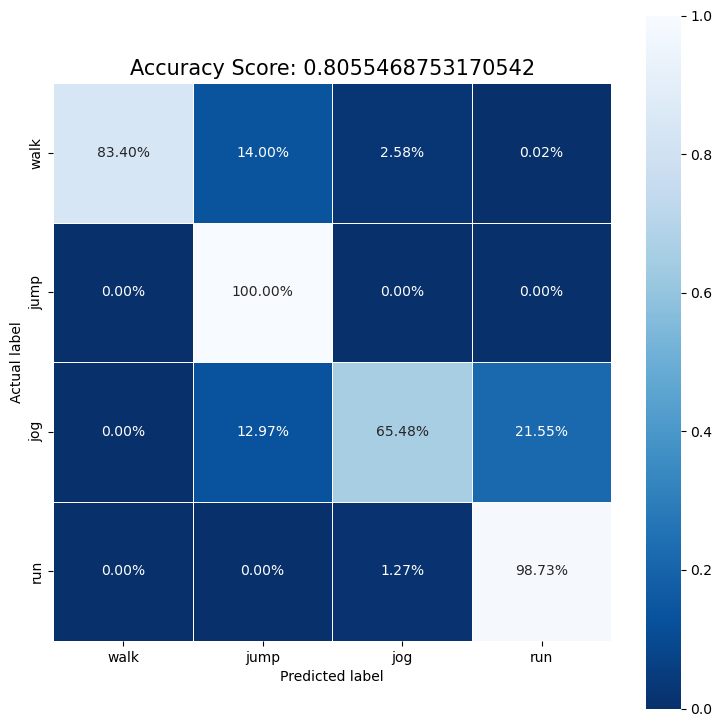

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

labels = df['ACTIVITY'].unique(maintain_order=True)
cm = metrics.confusion_matrix(y_test, predictions, labels=labels, normalize='true')

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".2%", linewidths=.5, square = True, cmap = 'Blues_r', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Accuracy Score: {score}'
plt.title(all_sample_title, size = 15)

In [106]:
import numpy as np
# Coefficients and Odds Ratios
coefficients = logisticRegr.coef_[0]
odds_ratios = np.exp(coefficients)


# Display feature importance using coefficients and odds ratios
feature_importance = pl.DataFrame({
    'Feature': df.select(pl.exclude(["ACTIVITY","TRIAL", "TIME"])).columns,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})
print("\nFeature Importance (Coefficient and Odds Ratio):")
print(feature_importance.sort(by='Coefficient', descending=True))


Feature Importance (Coefficient and Odds Ratio):
shape: (636, 3)
┌─────────────────────────┬─────────────┬────────────┐
│ Feature                 ┆ Coefficient ┆ Odds Ratio │
│ ---                     ┆ ---         ┆ ---        │
│ str                     ┆ f64         ┆ f64        │
╞═════════════════════════╪═════════════╪════════════╡
│ min_D7_Global Angle.y   ┆ 0.547362    ┆ 1.728687   │
│ std_D2_Global Angle.z   ┆ 0.500153    ┆ 1.648973   │
│ min_D4_Global Angle.y   ┆ 0.495652    ┆ 1.641568   │
│ mean_D7_Global Angle.y  ┆ 0.484354    ┆ 1.623126   │
│ last_D7_Global Angle.y  ┆ 0.479767    ┆ 1.615698   │
│ …                       ┆ …           ┆ …          │
│ min_D6_Global Angle.z   ┆ -0.582988   ┆ 0.558228   │
│ first_D6_Global Angle.z ┆ -0.614331   ┆ 0.541003   │
│ last_D6_Global Angle.z  ┆ -0.637925   ┆ 0.528388   │
│ mean_D6_Global Angle.z  ┆ -0.669808   ┆ 0.511807   │
│ max_D6_Global Angle.z   ┆ -0.702308   ┆ 0.49544    │
└─────────────────────────┴─────────────┴────────────┘

In [107]:
# from sklearn.inspection import permutation_importance

# # Permutation Importance
# perm_importance = permutation_importance(logisticRegr, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
# perm_importance_df = pl.DataFrame({
#     'Feature': df.select(pl.exclude(["ACTIVITY","TRIAL", "TIME"])).columns,
#     'Importance Mean': perm_importance.importances_mean,
#     'Importance Std': perm_importance.importances_std
# })

# print("\nPermutation Importance:")
# print(perm_importance_df.sort(by='Importance Mean', descending=True))
